In [3]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_momentum_flux/' 
output_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/Flux/output/'
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [4]:
#!jupyter nbconvert --to script numuCCana_xsec_flux_momentum.ipynb

In [5]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Flux variation, systematic

In [24]:
# Load input files
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"Flux_systematic.root","RECREATE");

#filename_overlay = 'Flux/NuCCana_overlay_flux_small.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
filename_data = 'NuCCana_data_V22.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [25]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =     8.649e+18  # best with tor875
data_trigger = 1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
pot_overlay = 1.22339196540357653e+21
print 'Overlay cott:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	33178
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		8.649e+18
Ext:		0
Overlay:	1.24025430537e+21
Overlay cott:	1.2233919654e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0976176954382
Overlay:	0.00706968841106
Dirt:		0.0691811002835


In [26]:
if 1:
    filename_overlay = filename_overlay+'out33.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out33.root'
    filename_ext = filename_ext+'out33.root'
    filename_dirt = filename_dirt+'out33.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	33177
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40807



In [9]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

Fiducial Volume:  49184671.35
Beam flux = 6.34870e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [46]:
#weight_list = {}
'''weight_list_all = [ 'All_Genie', 'AxFFCCQEshape_Genie', 'DecayAngMEC_Genie', 'MaNCRES_Genie', 'Theta_Delta2Npi_Genie', 'TunedCentralValue_Genie',\
    'VecFFCCQEshape_Genie', 'expskin_FluxUnisim', 'horncurrent_FluxUnisim', 'kminus_PrimaryHadronNormalization', 'kplus_PrimaryHadronFeynmanScaling',\
    'kzero_PrimaryHadronSanfordWang', 'nucleoninexsec_FluxUnisim', 'nucleonqexsec_FluxUnisim', 'nucleontotxsec_FluxUnisim',\
    'piminus_PrimaryHadronSWCentralSplineVariation', 'pioninexsec_FluxUnisim', 'pionqexsec_FluxUnisim', 'piontotxsec_FluxUnisim',\
    'piplus_PrimaryHadronSWCentralSplineVariation', 'splines_general_Spline' ]'''

weight_list_flux = [ 'expskin_FluxUnisim', 'horncurrent_FluxUnisim', 'kminus_PrimaryHadronNormalization', 'kplus_PrimaryHadronFeynmanScaling',\
    'kzero_PrimaryHadronSanfordWang', 'nucleoninexsec_FluxUnisim', 'nucleonqexsec_FluxUnisim', 'nucleontotxsec_FluxUnisim',\
    'piminus_PrimaryHadronSWCentralSplineVariation', 'pioninexsec_FluxUnisim', 'pionqexsec_FluxUnisim', 'piontotxsec_FluxUnisim',\
    'piplus_PrimaryHadronSWCentralSplineVariation' ]

weight_list_flux = [ 'root04', 'root06', 'kminus_PrimaryHadronNormalization', 'kplus_PrimaryHadronFeynmanScaling',\
    'kzero_PrimaryHadronSanfordWang', 'nucleoninexsec_FluxUnisim', 'nucleonqexsec_FluxUnisim', 'nucleontotxsec_FluxUnisim',\
    'piminus_PrimaryHadronSWCentralSplineVariation', 'pioninexsec_FluxUnisim', 'pionqexsec_FluxUnisim', 'piontotxsec_FluxUnisim',\
    'piplus_PrimaryHadronSWCentralSplineVariation' ]

num_para = len(weight_list_flux)
num_para = 2
print 'Nuber of parameters: ',num_para
#weight_list_genie_other = [ 'AxFFCCQEshape_Genie', 'DecayAngMEC_Genie', 'MaNCRES_Genie', 'Theta_Delta2Npi_Genie', 'VecFFCCQEshape_Genie' ]

Nuber of parameters:  2


In [49]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
num_universes = 10
eff_uni = np.zeros((num_para,num_universes))
mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1

In [50]:
path = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/Flux_1000/root_output/'
f = {}
f[0] = ROOT.TFile.Open('/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_cross_check/'+"expskin_FluxUnisimFlux_systematic_tmp1.root", 'read')
f[1] = ROOT.TFile.Open('/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_cross_check/'+"expskin_FluxUnisimFlux_systematic_tmp2.root", 'read')
    #h_data_mom = f[i].Get("h_data_mom")
    #print h_data_mom.GetEntries()
    
#h_data_mom.Draw()
#c1.Draw()
#h_data_mom.GetEntries()

In [51]:

h_ext_mom = f[0].Get("h_ext_mom")
h_data_mom = f[0].Get("h_data_mom")
h_dirt_mom = f[0].Get("h_dirt_mom")

bkg_ext = h_ext_mom.GetSumOfWeights()
num_data = h_data_mom.GetSumOfWeights()
bkg_dirt = h_dirt_mom.GetSumOfWeights()

print 'Data: ', num_data,' Ext: ', bkg_ext,' Dirt: ',bkg_dirt
h_ext_mom = f[1].Get("h_ext_mom")
h_data_mom = f[1].Get("h_data_mom")
h_dirt_mom = f[1].Get("h_dirt_mom")

bkg_ext = h_ext_mom.GetSumOfWeights()
num_data = h_data_mom.GetSumOfWeights()
bkg_dirt = h_dirt_mom.GetSumOfWeights()

print 'Data: ', num_data,' Ext: ', bkg_ext,' Dirt: ',bkg_dirt


Data:  1445.0  Ext:  158.531139612  Dirt:  36.498739481
Data:  1443.0  Ext:  157.652578115  Dirt:  36.2889559269


In [52]:

h_1d = []
h_1d_true = []

for para in range(num_para):
    h_1d.append([])
    h_1d_true.append([])
    for uni in range(num_universes):
        h_1d[para].append(f[para].Get('h_1d['+str(0)+']['+str(uni)+']'))
        h_1d_true[para].append( f[para].Get('h_1d_true['+str(0)+']['+str(uni)+']' ))

#for para in range(num_para):
for uni in range(num_universes):
    #print 'Get efficiency of Parameter: ', weight_list_flux[para]
    #for uni in range(num_universes):
    for para in range(num_para):
        #globale.overlay_out.Draw(variable+'>>h_1d['+str(para)+']['+str(uni)+']',weight_name+'*'+weight_list_flux[para]+'['+str(uni)+']*('+cut+'&& numu_signal)')
        #globale.overlay_out.Draw(variable+'>>h_1d_true['+str(para)+']['+str(uni)+']',weight_name+'*'+weight_list_flux[para]+'['+str(uni)+']*(numu_true)')
        num_signal = h_1d[para][uni].GetSumOfWeights()
        num_true = h_1d_true[para][uni].GetSumOfWeights()
        eff_uni[para][uni] = num_signal/(num_true+0.0001)
        #h_1d[para][uni].Write('h_1d['+str(para)+']['+str(uni)+']')
        #h_1d_true[para][uni].Write('h_1d_true['+str(para)+']['+str(uni)+']')
        print 'Parameter: ', weight_list_flux[para], ' Universe: ', uni, ' number of signal: ', num_signal,' True: ', num_true,' Eff: ',eff_uni[para][uni]
# save the efficiencies
#np.save(output_filedir+'xsec_flux_tot_efficiencies',eff_uni)
print 'Total std of efficiency (all parameters, all universes)',eff_uni.std()

Parameter:  root04  Universe:  0  number of signal:  143719.859253  True:  284034.78125  Eff:  0.5059938736018101
Parameter:  root06  Universe:  0  number of signal:  142792.828979  True:  284034.78125  Eff:  0.5027300822131944
Parameter:  root04  Universe:  1  number of signal:  157351.459961  True:  308544.478516  Eff:  0.5099798274366821
Parameter:  root06  Universe:  1  number of signal:  156325.92688  True:  308544.478516  Eff:  0.5066560503084832
Parameter:  root04  Universe:  2  number of signal:  143868.818726  True:  284305.427734  Eff:  0.5060361310069612
Parameter:  root06  Universe:  2  number of signal:  142940.675293  True:  284305.427734  Eff:  0.502771531242943
Parameter:  root04  Universe:  3  number of signal:  156966.590332  True:  307862.546875  Eff:  0.5098593248004855
Parameter:  root06  Universe:  3  number of signal:  155943.823975  True:  307862.546875  Eff:  0.5065371722117039
Parameter:  root04  Universe:  4  number of signal:  146433.999146  True:  288911.96

In [54]:

bkg_uni = np.zeros((num_para,num_universes))
h_1d_bkg = []
for para in range(num_para):
    h_1d_bkg.append([])
    for uni in range(num_universes):
        #print 'At universe: ',uni
        h_1d_bkg[para].append( f[para].Get('h_1d_bkg['+str(0)+']['+str(uni)+']') )

for uni in range(num_universes):
#for para in range(num_para):
    #print 'Get background of Parameter: ', weight_list_flux[para]
    for para in range(num_para):
    #for uni in range(num_universes):
        #globale.overlay_out.Draw(variable+'>>h_1d_bkg['+str(para)+']['+str(uni)+']',weight_name+'*'+weight_list_flux[para]+'['+str(uni)+']*('+cut+'&& !numu_signal)')
        #h_1d_bkg[para][uni].Scale(globale.scale[globale.overlay])
        bkg_uni[para][uni] = h_1d_bkg[para][uni].GetSumOfWeights()
        #h_1d_bkg[para][uni].Write('h_1d_bkg['+str(para)+']['+str(uni)+']')
        print 'Parameter: ', weight_list_flux[para], ' Universe: ', uni, ' Overlay: ',bkg_uni[para][uni]


Parameter:  root04  Universe:  0  Overlay:  214.80407619476318
Parameter:  root06  Universe:  0  Overlay:  214.05217266082764
Parameter:  root04  Universe:  1  Overlay:  235.37078666687012
Parameter:  root06  Universe:  1  Overlay:  234.44827461242676
Parameter:  root04  Universe:  2  Overlay:  215.0351800918579
Parameter:  root06  Universe:  2  Overlay:  214.28137063980103
Parameter:  root04  Universe:  3  Overlay:  234.79396629333496
Parameter:  root06  Universe:  3  Overlay:  233.876238822937
Parameter:  root04  Universe:  4  Overlay:  218.90094232559204
Parameter:  root06  Universe:  4  Overlay:  218.11506366729736
Parameter:  root04  Universe:  5  Overlay:  234.1789846420288
Parameter:  root06  Universe:  5  Overlay:  233.26628875732422
Parameter:  root04  Universe:  6  Overlay:  213.8007550239563
Parameter:  root06  Universe:  6  Overlay:  213.05716037750244
Parameter:  root04  Universe:  7  Overlay:  226.93526887893677
Parameter:  root06  Universe:  7  Overlay:  226.082791805267

In [57]:
xsec_uni = np.zeros((num_para,num_universes))
h_1d_xsec = []

for para in range(num_para):
    h_1d_xsec.append([])
    for uni in range(num_universes):
        #print 'At universe: ',uni
        h_1d_xsec[para].append( ROOT.TH1F('h_1d_xsec['+str(para)+']['+str(uni)+']',"xsec momentum",binnum,array('f',mom_bins)) )
        
xsec_std = np.zeros((num_para))
xsec_mean = np.zeros((num_para))
xsec_diff = np.zeros((num_para))
xsec_CV = 7.6770041506e-39
xsec_diff_tot = 0

#for para in range(num_para):
#    for uni in range(num_universes):
for uni in range(num_universes):
    for para in range(num_para):
        signal = num_data - bkg_ext - bkg_dirt - bkg_uni[para][uni]
        xsec_uni[para][uni] = (num_data - bkg_ext - bkg_dirt - bkg_uni[para][uni])/(eff_uni[para][uni] * N_tot * beam_flux)
        #globale.overlay_out.Draw(variable+">>h_1d_bkg["+str(uni)+']',weight_name+'*All_Genie['+str(uni)+']*('+cut+'&& !numu_signal)')
        #h_1d_xsec[uni].Scale(globale.scale[globale.overlay])
        #xsec_uni[uni] = h_1d_bkg[uni].GetSumOfWeights()
        print 'Parameter: ', weight_list_flux[para], ' Universe: ', uni, ' Total fulux integrated xsec: ',xsec_uni[para][uni]
    xsec_std[para] = np.std(xsec_uni[para])
    xsec_mean[para] = np.mean(xsec_uni[para])
    xsec_diff[para] = xsec_std[para]*100.0/xsec_CV
    #print 'Parameter: %6s'% weight_list_flux[para], ' mean: {0:0.3e}%'.format(xsec_mean[para]), ' standart deviation: {0:0.3e}%'.format(xsec_std[para]),' in percent: {0:0.3f}%'.format(xsec_diff[para],'%')
    xsec_diff_tot = xsec_diff_tot + xsec_diff[para]*xsec_diff[para]
    
xsec_diff_tot = math.sqrt(xsec_diff_tot)
print 'Total flux errorin percent: {0:0.5f}%'.format(xsec_diff_tot,'%')
print 'data,ext,dirt,n_tot,flux',num_data,bkg_ext,bkg_dirt,N_tot,beam_flux

Parameter:  root04  Universe:  0  Total fulux integrated xsec:  7.846259559800907e-39
Parameter:  root06  Universe:  0  Total fulux integrated xsec:  7.902939801256097e-39
Parameter:  root04  Universe:  1  Total fulux integrated xsec:  7.630126300083321e-39
Parameter:  root06  Universe:  1  Total fulux integrated xsec:  7.6871710285552e-39
Parameter:  root04  Universe:  2  Total fulux integrated xsec:  7.843851246169859e-39
Parameter:  root06  Universe:  2  Total fulux integrated xsec:  7.900538344395693e-39
Parameter:  root04  Universe:  3  Total fulux integrated xsec:  7.636272450819682e-39
Parameter:  root06  Universe:  3  Total fulux integrated xsec:  7.693310147129576e-39
Parameter:  root04  Universe:  4  Total fulux integrated xsec:  7.802033359715602e-39
Parameter:  root06  Universe:  4  Total fulux integrated xsec:  7.858794405654912e-39
Parameter:  root04  Universe:  5  Total fulux integrated xsec:  7.642310688580977e-39
Parameter:  root06  Universe:  5  Total fulux integrated

In [16]:
# check standard deviations on the true efficiency
np.std(eff_uni)
#Since the efficiency does not change very much per universe the nominal efficiency e_tilde is used
# in order not to calculated the whole detector smearing again
eff_tilde = np.load(input_filedir+'eff_tilde_momentum_xsec_CV.npy')
print eff_tilde

[0.20982139 0.34924993 0.45501729 0.53793668 0.61080753 0.63447142
 0.58437668]


In [17]:

for para in range(num_para):
    xsec_uni_bin = np.zeros((num_universes,binnum))
    for uni in range(num_universes):
        for i in range(binnum):
            xsec_uni_bin[uni][i] = h_data_mom.GetBinContent(i+1) - h_ext_mom.GetBinContent(i+1) - h_dirt_mom.GetBinContent(i+1) - h_1d_bkg[para][uni].GetBinContent(i+1)
            xsec_uni_bin[uni][i] = xsec_uni_bin[uni][i]/(eff_tilde[i] * N_tot * beam_flux * h_data_mom.GetBinWidth(i+1))
    #print xsec_uni_bin

    xsec_std_bin = np.std(xsec_uni_bin,axis=0)
    #print xsec_std_bin
    np.save(output_filedir+'xsec_'+weight_list_flux[para]+'_momentum',xsec_std_bin)

In [18]:
# save the total difference in percent
np.save(output_filedir+'xsec_percent_diff_momentum',xsec_std_bin)

In [19]:
# close the root file with all the histos
RootFile.Close()

In [20]:
# load CV values
path = '/home/tmettler/Desktop/ub_data/mcc9.1/v08_00_00_33/V08_00_00_35/weighted/xsec_files/'
f_cv = ROOT.TFile.Open(path+"xsec_momentum_wighted.root", 'read')
h_overlay_cv = ROOT.TH1F('h_overlay_cv',"xsec momentum",binnum,array('f',mom_bins))
h_overlay_cv = f_cv.Get("h_overlay")
h_cv =  h_data_mom.Clone()
h_cv.Add(h_ext_mom,-1)
h_cv.Add(h_dirt_mom,-1)
h_cv.Add(h_overlay_cv,-1)
h_cv.Scale(1.0/(N_tot * beam_flux ))
h_cv.SetLineColor(1)
for i in range(1,binnum+1):
    value = h_cv.GetBinContent(i)
    width = h_cv.GetBinWidth(i)
    h_cv.SetBinContent(i,value/(width*eff_tilde[i-1]))
    
h_cv.SetYTitle("d\sigma / dp \quad [cm^2/GeV]")
h_cv.SetXTitle("p_{\mu} \quad [GeV]")
#h_cv.SetMaximum(h_1d_xsec[0][0].GetMaximum()*1.1)
h_cv.SetMinimum(0)

In [21]:
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


100


Info in <TCanvas::Print>: png file h_1d_xsec_all_flux.png has been created
Info in <TCanvas::SaveAs>: ROOT file h_1d_xsec_all_flux.root has been created


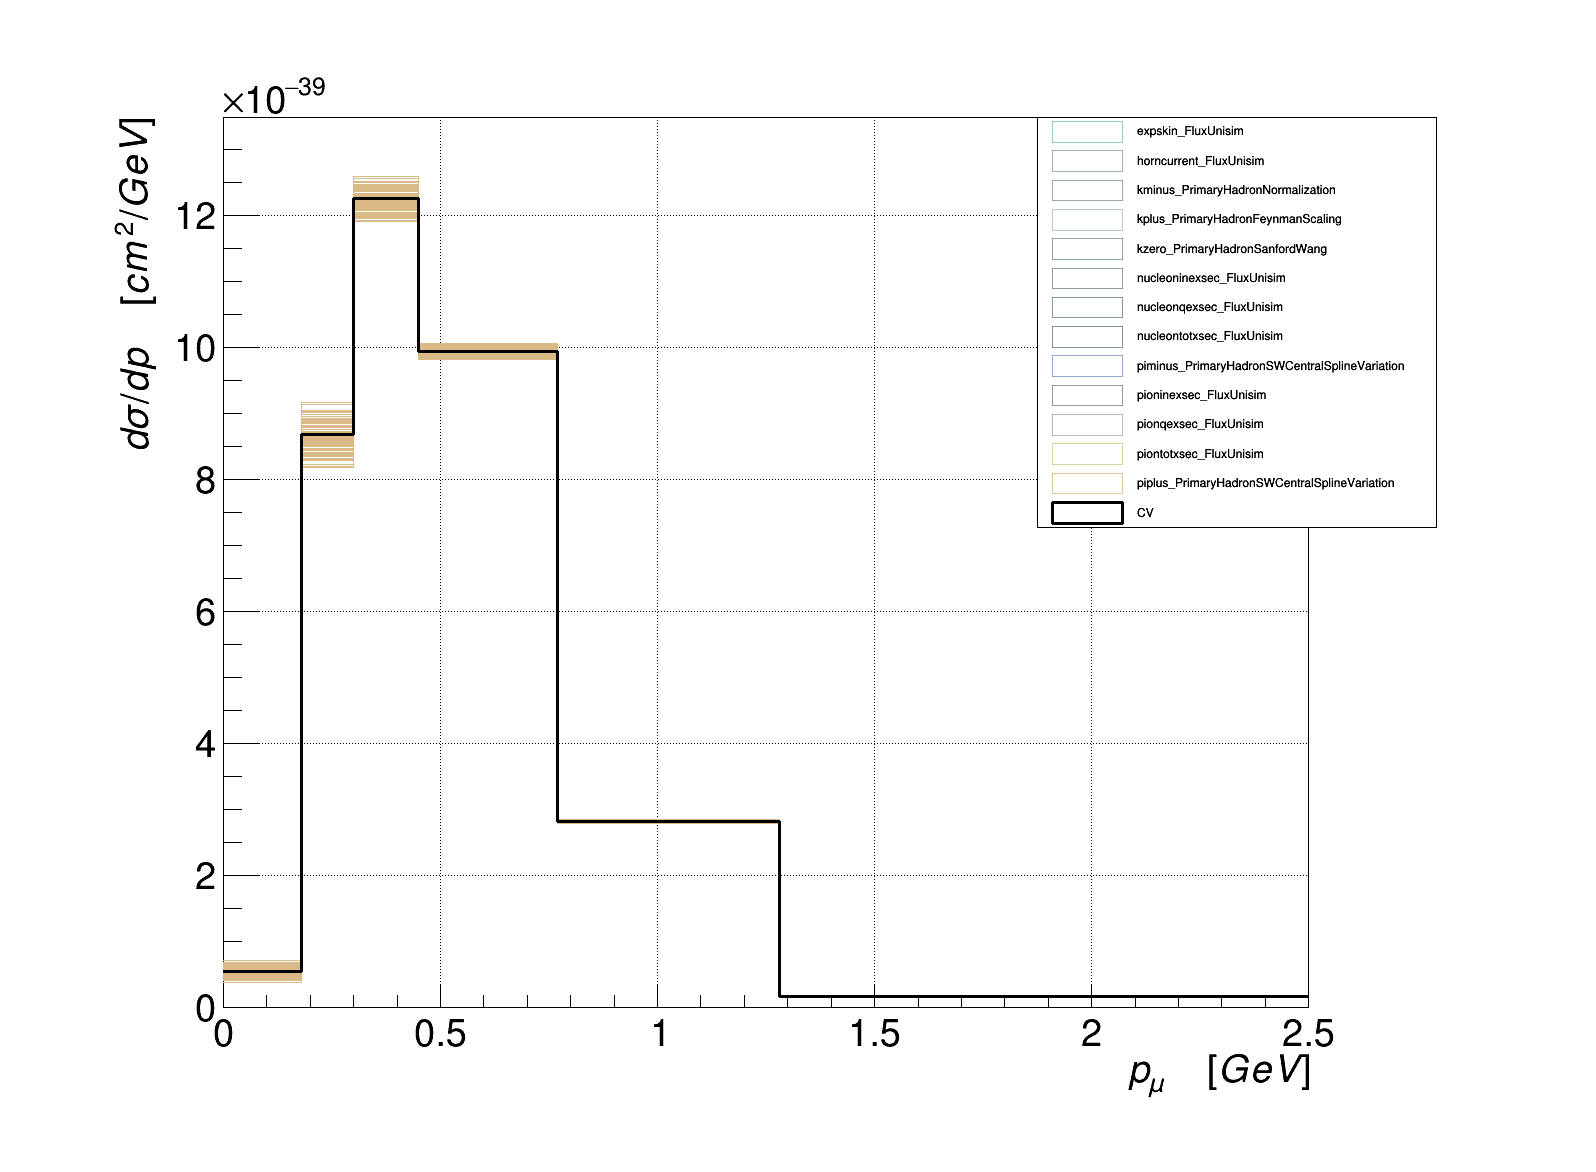

In [22]:
h_1d_xsec = []
print num_universes
for para in range(num_para):
    h_1d_xsec.append([])
    for uni in range(num_universes):
        #print 'At universe: ',uni
        h_1d_xsec[para].append( ROOT.TH1F('h_1d_xsec['+str(para)+']['+str(uni)+']',"xsec momentum",binnum,array('f',mom_bins)) )

legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
#legend = ROOT.TLegend(0.15,0.65,0.3,0.9) # LEGEND LEFT    weight_list_flux[para]    

for para in range(num_para):
    for uni in range(num_universes):     
        #xsec_uni_bin[uni][i] = h_data_mom.GetBinContent(i+1) - h_ext_mom.GetBinContent(i+1) - h_dirt_mom.GetBinContent(i+1) - h_1d_bkg[para][uni].GetBinContent(i+1)
        #xsec_uni_bin[uni][i] = xsec_uni_bin[uni][i]/(eff_tilde[i] * N_tot * beam_flux * h_data_mom.GetBinWidth(i+1))
        h_1d_xsec[para][uni] = h_data_mom.Clone()
        h_1d_xsec[para][uni].Add(h_ext_mom,-1)
        h_1d_xsec[para][uni].Add(h_dirt_mom,-1)
        h_1d_xsec[para][uni].Add(h_1d_bkg[para][uni],-1)
        h_1d_xsec[para][uni].Scale(1.0/(N_tot * beam_flux))
        h_1d_xsec[para][uni].SetLineColorAlpha(para+30,0.8)
        h_1d_xsec[para][uni].SetLineWidth(1)
        for i in range(1,binnum+1):
            value = h_1d_xsec[para][uni].GetBinContent(i)
            width = h_1d_xsec[para][uni].GetBinWidth(i)
            h_1d_xsec[para][uni].SetBinContent(i,value/(width*eff_tilde[i-1]))
            #print i, value/width
    legend.AddEntry(h_1d_xsec[para][uni],weight_list_flux[para],"f")
    
legend.AddEntry(h_cv,'CV',"f")
h_cv.SetLineWidth(3)
h_cv.SetMaximum(h_cv.GetMaximum()*1.1)
h_cv.Draw('HIST')
for para in range(num_para):
    for uni in range(num_universes):        
        h_1d_xsec[para][uni].Draw('HIST same ')
legend.Draw()
h_cv.Draw('HIST same')
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_1d_xsec_all_flux.png")
c1.SaveAs(globale.outputdir_root + "h_1d_xsec_all_flux.root")

In [23]:
print len(h_1d_xsec[1])
# initialte ROOT default canvas
#ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptTitle(0)
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

100


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


Info in <TCanvas::Print>: png file h_1d_bkg_all_flux.png has been created
Info in <TCanvas::SaveAs>: ROOT file h_1d_bkg_all_flux.root has been created


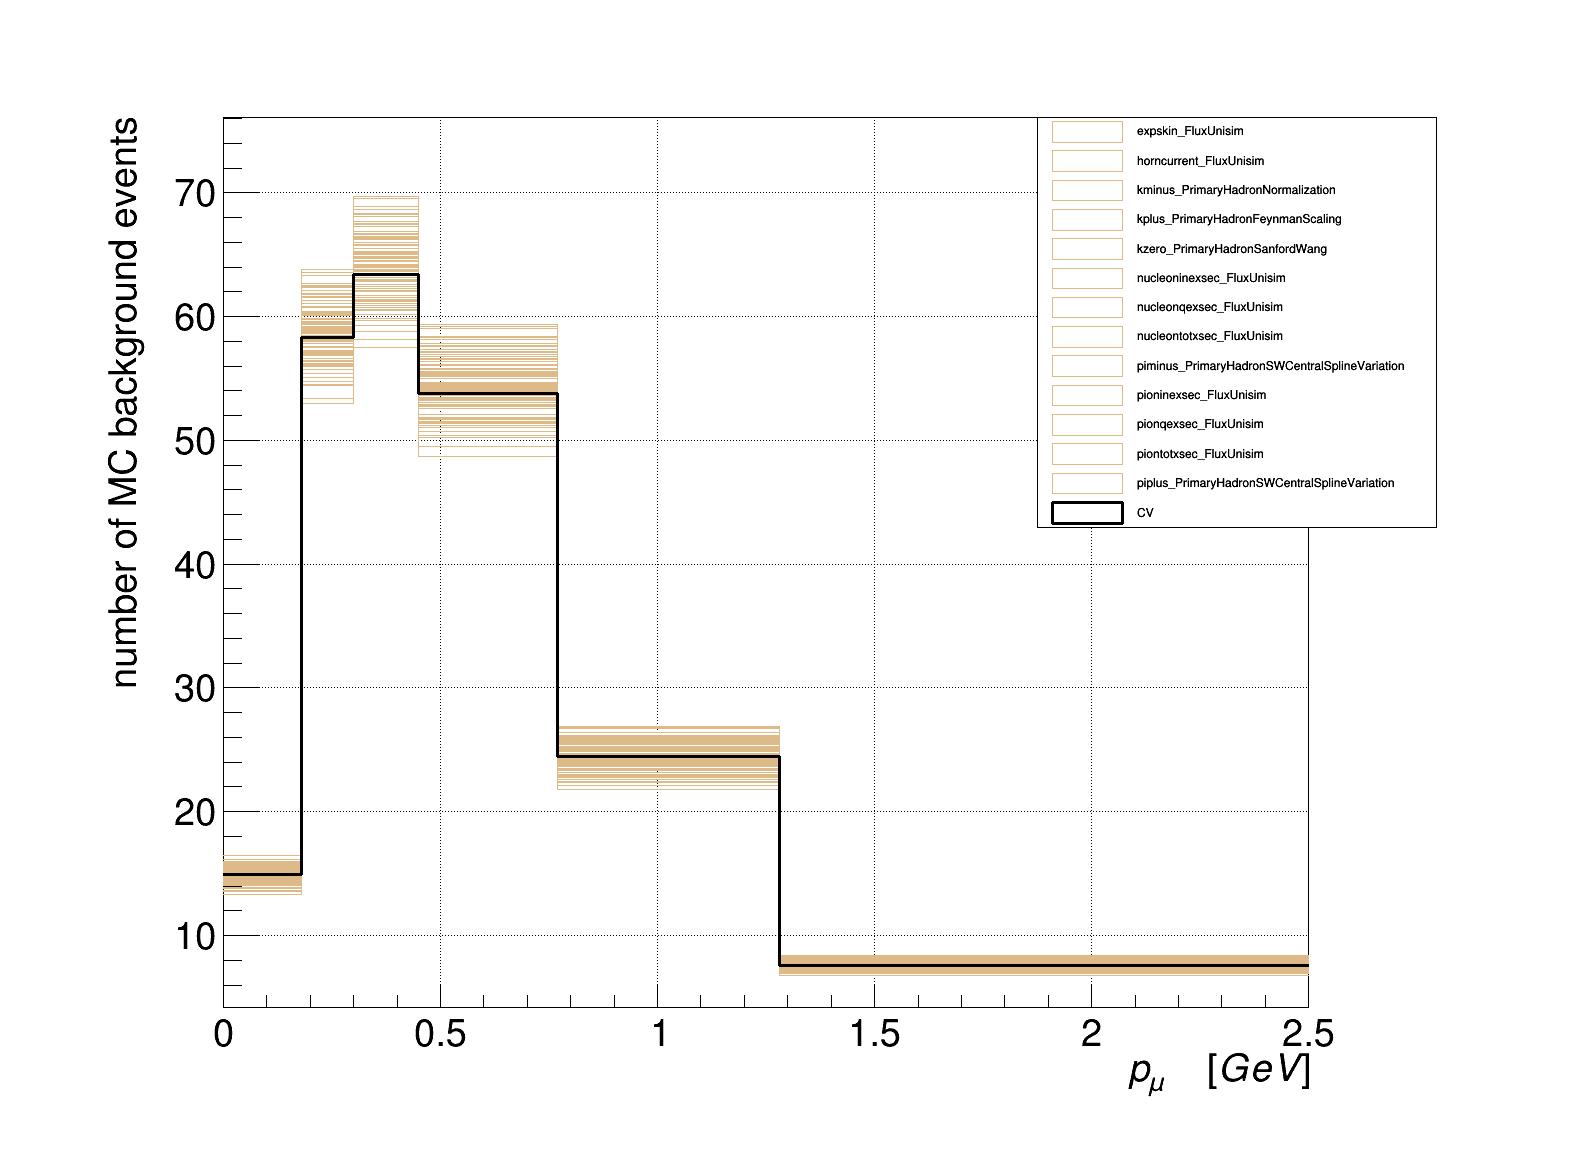

In [24]:
legend = ROOT.TLegend(0.65,0.55,0.9,0.9); #LEGEND RIGHT
h_overlay_cv.SetLineWidth(3)
h_overlay_cv.SetLineColor(1)
h_overlay_cv.SetYTitle("number of MC background events")
h_overlay_cv.SetXTitle("p_{\mu} \quad [GeV]")
h_overlay_cv.SetMaximum(h_overlay_cv.GetMaximum()*1.2)
h_overlay_cv.Draw('HIST')
for para in range(num_para):
    for uni in range(num_universes):   
        h_1d_bkg[para][uni].SetLineColor(para+30)
        h_1d_bkg[para][uni].SetLineWidth(1)
        h_1d_bkg[para][uni].Draw('HIST same')
    legend.AddEntry(h_1d_bkg[para][uni],weight_list_flux[para],"f")
legend.AddEntry(h_overlay_cv,'CV',"f")        
legend.Draw()
h_overlay_cv.Draw('HIST same')
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_1d_bkg_all_flux.png")
c1.SaveAs(globale.outputdir_root + "h_1d_bkg_all_flux.root")

In [25]:
'''# ROOT.TH1F('h_1d_xsec['+str(para)+']['+str(uni)+']',"xsec momentum",binnum,array('f',mom_bins)) )
mom_binsy = [ 0.00, 1e-39,2e-39, 3e-39 ]
mom_binsy = np.arange(0, 3e-39, 0.1e-39).tolist()
binnumy = len(mom_binsy) - 1
xsec_col = ROOT.TH2F('xsec_col','Fluxreweighting',binnum,array('f',mom_bins),binnumy, array('f',mom_binsy))
#h_1d_xsec[0][0].Draw()
for para in range(1):
    for uni in range(num_universes):        
        h_1d_xsec[para][uni].Draw('HIST same ')
'''

'# ROOT.TH1F(\'h_1d_xsec[\'+str(para)+\'][\'+str(uni)+\']\',"xsec momentum",binnum,array(\'f\',mom_bins)) )\nmom_binsy = [ 0.00, 1e-39,2e-39, 3e-39 ]\nmom_binsy = np.arange(0, 3e-39, 0.1e-39).tolist()\nbinnumy = len(mom_binsy) - 1\nxsec_col = ROOT.TH2F(\'xsec_col\',\'Fluxreweighting\',binnum,array(\'f\',mom_bins),binnumy, array(\'f\',mom_binsy))\n#h_1d_xsec[0][0].Draw()\nfor para in range(1):\n    for uni in range(num_universes):        \n        h_1d_xsec[para][uni].Draw(\'HIST same \')\n'

In [26]:
xsec_cov_matrix = np.zeros((binnum,binnum)) # covariance matrix
xsec_corr_matrix = np.zeros((binnum,binnum)) # correlation matrix
xsec_frac_cov_matrix = np.zeros((binnum,binnum)) # fractional covariance matrix

for para in range(num_para):#num_para
    for uni in range(num_universes):    #num_universes 
        xsec_diff_matrix = np.zeros((binnum))
        xsec_diff_matrix_1 = np.zeros((binnum))
        for i in range(1,binnum+1):
            xsec_var = h_1d_xsec[para][uni].GetBinContent(i)
            xsec_cv = h_cv.GetBinContent(i)
            xsec_diff_matrix[i-1] = xsec_var - xsec_cv
            xsec_diff_matrix_1[i-1] = (xsec_var - xsec_cv)/(xsec_cv+1e-80)
        xsec_cov_matrix = xsec_cov_matrix + xsec_diff_matrix.reshape(binnum,1) * xsec_diff_matrix
        xsec_frac_cov_matrix = xsec_frac_cov_matrix + xsec_diff_matrix_1.reshape(binnum,1) * xsec_diff_matrix_1
for i in range(binnum):
    for j in range(binnum):
        xsec_corr_matrix[i][j] = xsec_cov_matrix[i][j]/(math.sqrt(xsec_cov_matrix[i][i]*xsec_cov_matrix[j][j]))
    

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_flux//png/h_covariance_flux.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_flux//root/h_covariance_flux.root has been created


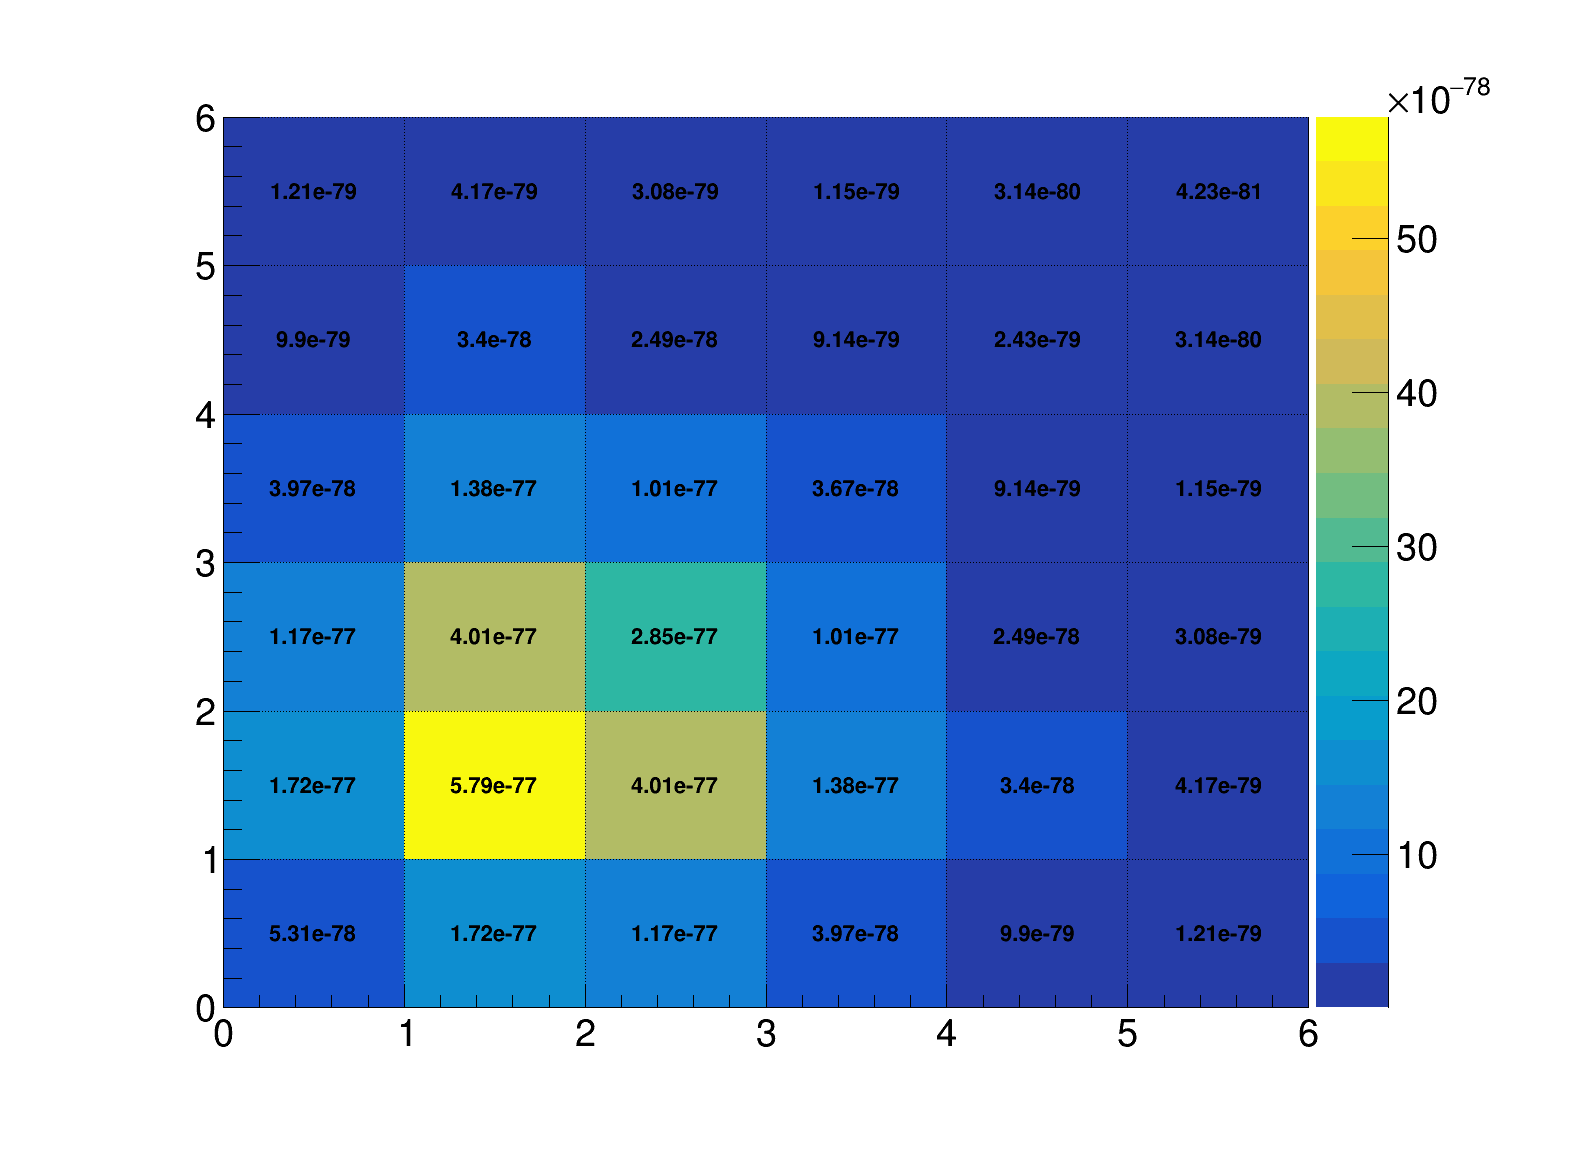

In [27]:
ROOT.gStyle.SetPaintTextFormat('0.3g')
h_covariance = ROOT.TH2D("h_covariance",'Covariance matrix',6,0,6,6,0,6)
for i in range(binnum):
    for j in range(binnum):
        h_covariance.SetBinContent(i+1,j+1,xsec_cov_matrix[i,j])
#h_covariance.SetMinimum(-1)
h_covariance.Draw('colz')
h_covariance.Draw('same text')
c1.Draw()
c1.SaveAs(outputdir_png + "h_covariance_flux.png")
c1.SaveAs(outputdir_root + "h_covariance_flux.root")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_flux//png/h_frac_covariance_flux.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_flux//root/h_frac_covariance_flux.root has been created


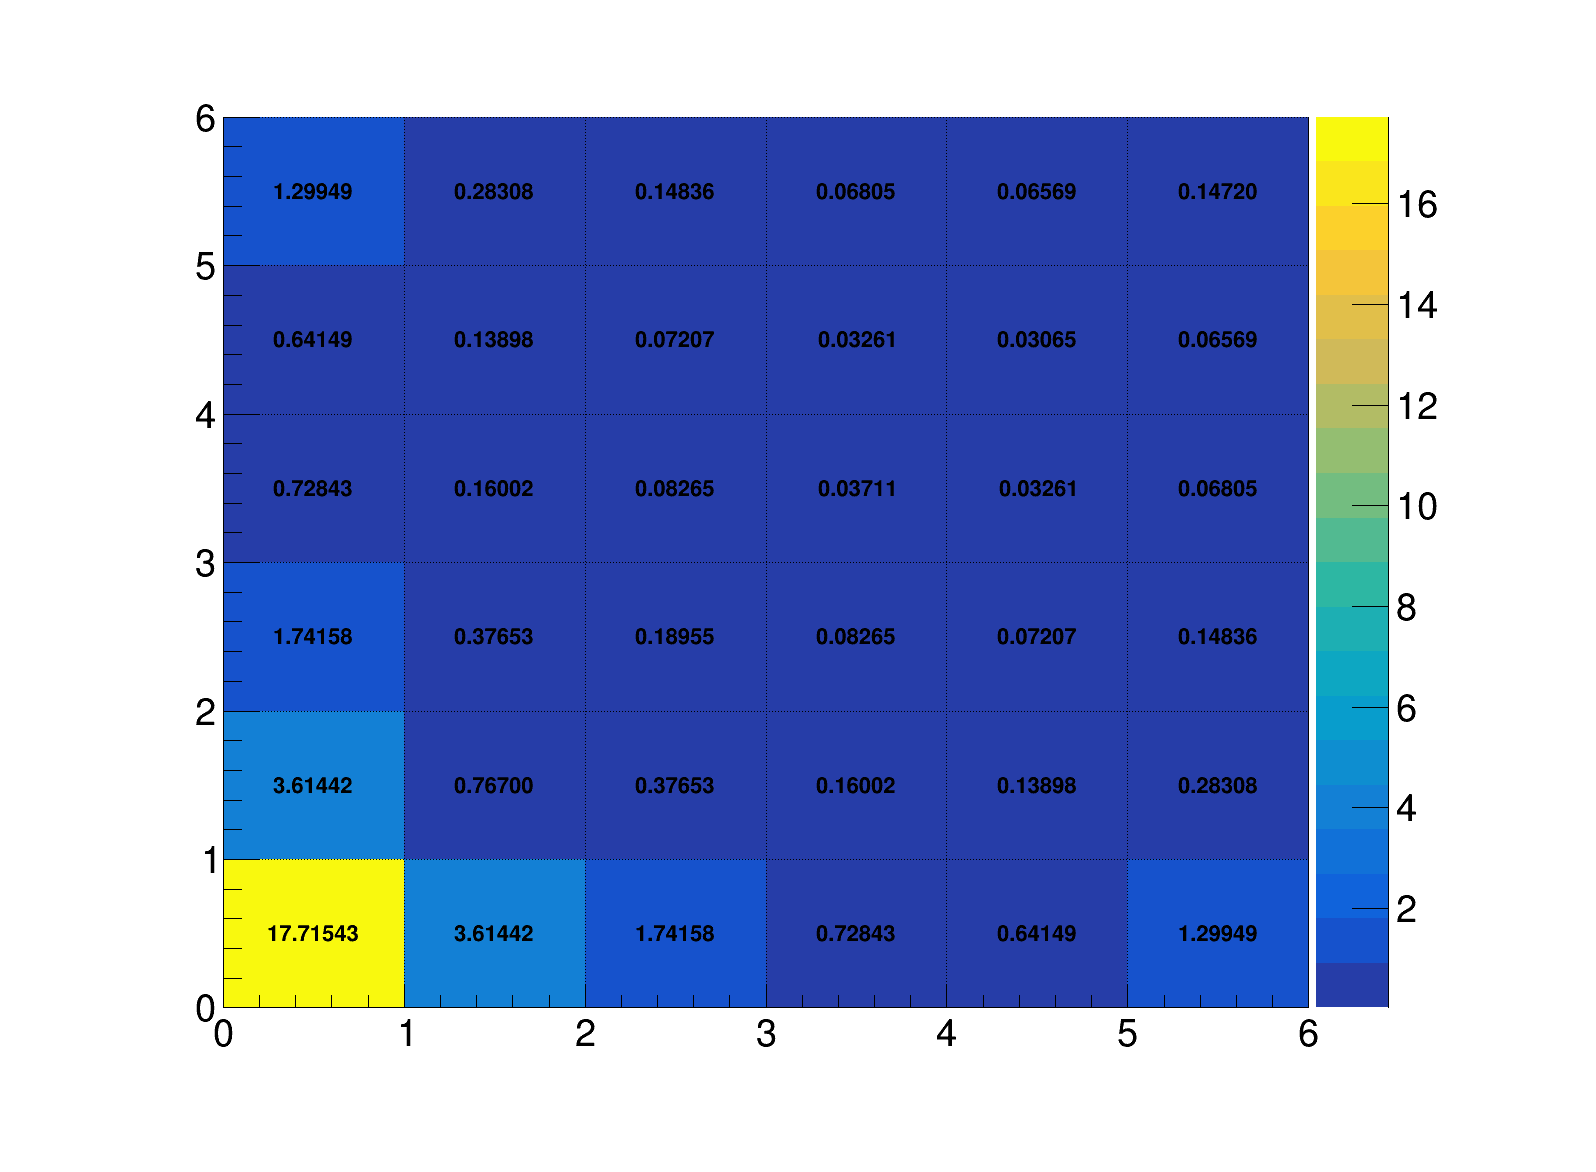

In [28]:
ROOT.gStyle.SetPaintTextFormat('0.5f')
h_frac_covariance = ROOT.TH2D("h_frac_covariance",'Fractional covariance matrix',6,0,6,6,0,6)
for i in range(binnum):
    for j in range(binnum):
        h_covariance.SetBinContent(i+1,j+1,xsec_frac_cov_matrix[i,j])
#h_covariance.SetMinimum(-1)
h_covariance.Draw('colz')
h_covariance.Draw('same text')
c1.Draw()
c1.SaveAs(outputdir_png + "h_frac_covariance_flux.png")
c1.SaveAs(outputdir_root + "h_frac_covariance_flux.root")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_flux//png/h_correlation_flux.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_flux//root/h_correlation_flux.root has been created


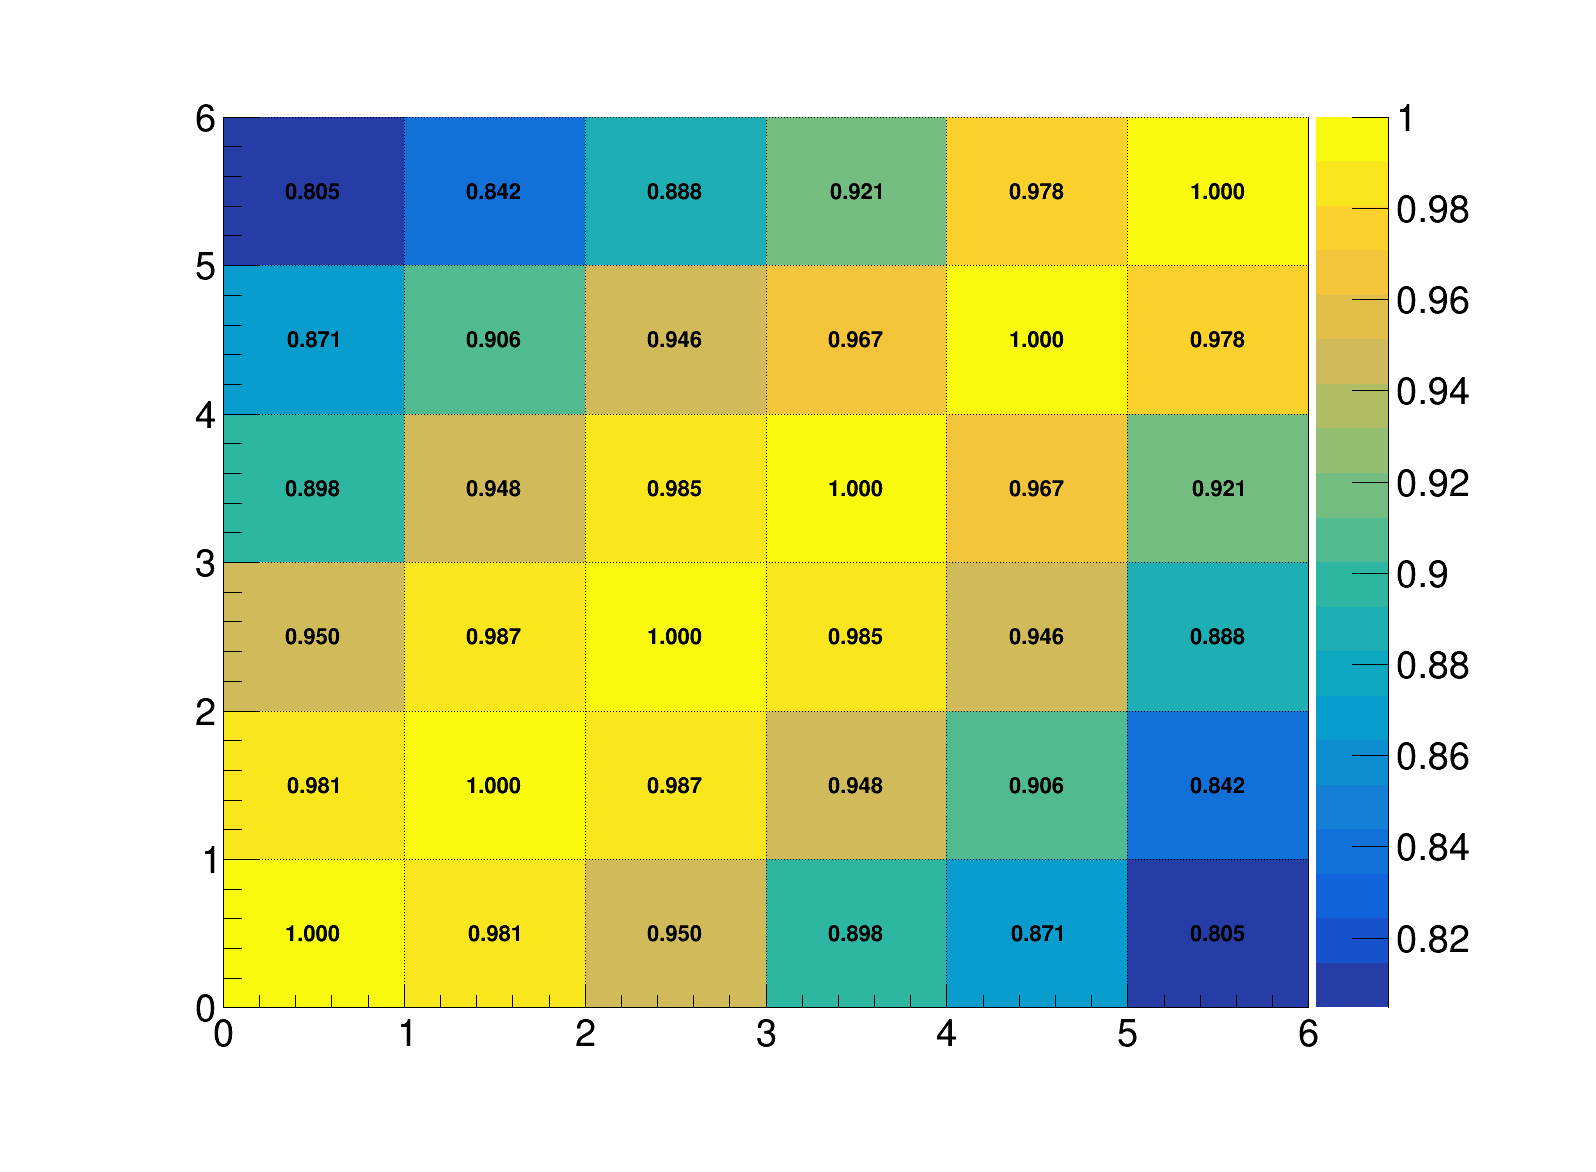

In [29]:
ROOT.gStyle.SetPaintTextFormat('0.3f')
h_correlation = ROOT.TH2D("h_correlation",'Correlation matrix',6,0,6,6,0,6)
for i in range(binnum):
    for j in range(binnum):
        h_correlation.SetBinContent(i+1,j+1,xsec_corr_matrix[i,j])
#h_correlation.SetMinimum(-1)
h_correlation.Draw('colz')
h_correlation.Draw('same text')
c1.Draw()
c1.SaveAs(outputdir_png + "h_correlation_flux.png")
c1.SaveAs(outputdir_root + "h_correlation_flux.root")

In [36]:
fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = fidVol+' && '+MCfidVol+' && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = MCfidVol+' && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = fidVol+' && '+MCfidVol+' && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = fidVol+' && '+MCfidVol+' && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = fidVol+' && '+MCfidVol+' && MCNu_CCNC==1' # nutral current
numu_ov = fidVol+' && !'+MCfidVol+'' # out of fiducial
numu_other = fidVol+' && '+MCfidVol+' && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue

track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && ('+track_end_uncontained+'==1 || nr_crthit_beam_tres==0) && (abs(crtt0_time-4)<0.8 || crtt0_time==-1)'

cut = fidVol+' && (key_muon==track_key) && '+crt_tom_cut+' && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

print cut

(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50)) && (key_muon==track_key) && nr_crthit_top==0 && crthit_vertex_zcut==0 && (((TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1)) || (TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1)) || (TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1)))==1 || nr_crthit_beam_tres==0) && (abs(crtt0_time-4)<0.8 || crtt0_time==-1) && TrackScore>0.8                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1


In [37]:
print overlay_out.GetEntries(cut)

157507


In [31]:
print overlay_out.GetEntries(crt_tom_cut+'&&'+fidVol+' && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

161739


In [34]:
print overlay_out.GetEntries(fidVol+' && (key_muon==track_key) && '+crt_tom_cut+' && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

157507
